In [1]:
import sympy
from sympy import Symbol, sqrt, cos, pi, symbols
import numpy as np
import matplotlib.pylab as plt

import qnet
from qnet.algebra import *

import QDYN

from notebook_plots import plot_bs_decay, display_hamiltonian, display_eq, show_summary_dicke
from single_sided_network import network_slh
from single_sided_node import node_slh
from qdyn_model import make_qdyn_oct_model

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
qnet.init_printing()

$
\newcommand{ket}[1]{\vert #1 \rangle}
\newcommand{bra}[1]{\langle #1 \vert}
\newcommand{Op}[1]{\hat{#1}}
$

# Optimized Initialization of a Dicke State

## System description

### Description of a network node

Each node of our network consists of a driven $\Lambda$-type atom embedded in a cavity [@CiracPRL1997]. After adiabatic elimination of the $\ket{r}$-state, the Hamiltonian and Lindblad operator of the node read

In [4]:
slh_node = node_slh(1, n_cavity=4)
display_hamiltonian(slh_node.H)

<IPython.core.display.Latex object>

and

In [5]:
display_eq('\Op{L} ', slh_node.L)

<IPython.core.display.Latex object>

respectively.

Adding a coherent displacement feeding into the node additionally drives the cavity:

In [6]:
Ω_α, α = symbols('Omega_alpha alpha')
κ = Symbol('kappa', positive=True); λ = Symbol('lambda', real=True)
H_node_driven = (slh_node << qnet.cc.Displace('W', alpha=α)).toSLH().H.substitute(
    {α: λ/sqrt(2*κ) * Ω_α.conjugate()})
H_node_driven

-I*Ω_1*g_1/(2*Δ_1) * (σ̂_e,g^(q₁) ⊗ â^(c₁) - σ̂_g,e^(q₁) ⊗ â^(c₁)†) + g_1**2/Δ_1 * Π̂_g^(q₁) ⊗ â^(c₁)† â^(c₁) + I/2 * (-λ*conjugate(Ω_α) * â^(c₁)† + Ωₐₗₚₕₐ⋅λ * â^(c₁)) - g_1**2/Δ_1 * â^(c₁)† â^(c₁)

Here, we have renormalized the displacement amplitude as $\alpha \rightarrow \frac{\lambda \Omega_\alpha^*}{\sqrt{2 \kappa}}$. The factor $\sqrt{2\kappa}$ ensures that $\Omega_a$ is in units of energy, and the dimensionless $\lambda = g_1 / \Delta_1$ rescales $\Omega_\alpha$ have comparable amplitudes as $\Omega_1$.

It is instructive to write out this Hamiltonian in a matrix representation,

In [7]:
display_eq('\Op{H}', qnet.convert.convert_to_sympy_matrix(H_node_driven))

<IPython.core.display.Latex object>

where the rows/colums correspond to the following quantum numbers:

In [8]:
slh_node.H.space.basis_labels

('g,0', 'g,1', 'g,2', 'g,3', 'e,0', 'e,1', 'e,2', 'e,3')

This illustrates how the static interaction Hamiltonian $\Op{H}_{\text{int}}$ acts to shift a subset of levels into resonance:
* The driven sideband $\ket{g, n+1} \leftrightarrow \ket{e, n}$ via the control $\Omega_1$ is resonant only for $n=0$, but is detuned by $n \frac{g^2}{\Delta}$ for $n > 0$.
* The driven excitation of the cavity $\ket{g/e, n} \leftrightarrow \ket{g/e, n+1}$ via the control $\Omega_{\alpha}$ is resonant only for the ground state $\ket{g}$ of the qubit, but is detuned by $n \frac{g^2}{\Delta}$ when the qubit is in the excited state $\ket{e}$

### Network of multiple nodes

We now consider `n_nodes` of the above nodes, with feedback through a beamsplitter

In [9]:
n_nodes = 2

The cavity is truncated at

In [10]:
n_cavity = 2

In [11]:
slh = network_slh(n_cavity=n_cavity, n_nodes=n_nodes, topology='driven_bs_fb')

The Lindblad operator of the total network corresponds to the sum of Lindblad operators of the individual nodes

In [12]:
display_eq('\Op{L}', slh.L)

<IPython.core.display.Latex object>

Note that this allows for constructive or destructive interference between the individual terms: The system is in a *dark state* if $\bra{\Psi} \Op{L} \ket{\Psi} = 0$

The presence of the beamsplitter results in the decay rate depending on the mixing angle $\theta$ of the beamsplitter

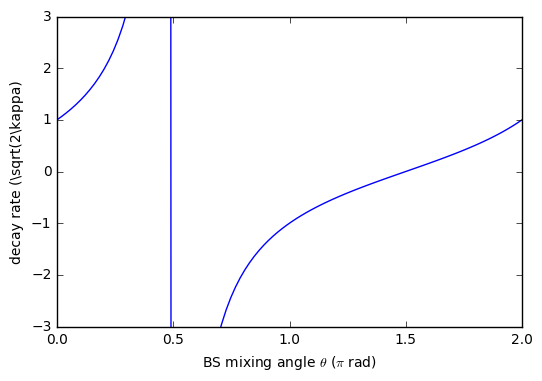

In [13]:
plot_bs_decay(slh.Ls[0])

In [14]:
θ = Symbol('theta', real=True)
slh.L.substitute({θ: 3*sympy.pi/2}).simplify_scalar()

[[0]]

The Hamiltonian of the entire network reads as

In [15]:
display_hamiltonian(slh.H.substitute({λ: Symbol('g') / (Symbol('Delta')) }))

<IPython.core.display.Latex object>

In [16]:
display_hamiltonian(slh.H.substitute({λ: Symbol('g') / (Symbol('Delta')), θ:0}))

<IPython.core.display.Latex object>

## Dimensionless Units and Choice of Parameters

All of the symbols in the Hamiltonian (including the control fields) are in units of energy. In order to work with dimensionless numbers, we express these energies in units of $g$. This implies time units of $\hbar/g$.

The controls are

In [17]:
control_syms = sorted([sym for sym in slh.H.all_symbols() if sym.name.startswith('Omega')], key=str)
control_syms

This leaves the remaining free symbols

In [18]:
syms = slh.all_symbols().difference(control_syms);
syms

which we set as follows, with all nodes having identical parameters

In [19]:
Delta =   100.0
g     =     1.0 # by definition
kappa =     0.01
E0    =     1.4
theta = 0.0 * np.pi
num_vals = {
    Symbol('kappa', positive=True): kappa,
    Symbol('theta', real=True):     theta,
    Symbol('lambda', real=True): g / Delta,
}
for i_node in range(n_nodes):
    num_vals[Symbol('Delta_%d' % (i_node + 1), real=True)] = Delta
    num_vals[Symbol('g_%d' % (i_node + 1), positive=True)] = g
num_vals

In total, this leads to the following scalar coefficients in the Hamiltonian

In [20]:
{str(t.coeff): t.coeff.subs(num_vals) for t in pattern(head=ScalarTimesOperator).findall(slh.H)}

{'-I*Omega_1*g_1/(2*Delta_1)': -0.005*I*Omega_1,
 '-I*Omega_2*g_2/(2*Delta_2)': -0.005*I*Omega_2,
 '-I*kappa': -0.01*I,
 '-g_1**2/Delta_1': -0.0100000000000000,
 '-g_2**2/Delta_2': -0.0100000000000000,
 '-sqrt(2)*I*Omega_alpha*lambda*cos(theta)/(2*sin(theta) - 2)': 0.005*sqrt(2)*I*Omega_alpha,
 'I*Omega_1*g_1/(2*Delta_1)': 0.005*I*Omega_1,
 'I*Omega_2*g_2/(2*Delta_2)': 0.005*I*Omega_2,
 'I*kappa': 0.01*I,
 'g_1**2/Delta_1': 0.0100000000000000,
 'g_2**2/Delta_2': 0.0100000000000000,
 'sqrt(2)*I*lambda*cos(theta)*conjugate(Omega_alpha)/(2*(sin(theta) - 1))': -0.005*sqrt(2)*I*conjugate(Omega_alpha)}

## Overview of the Protocol

Note that except for $\Op{H}_{\alpha}$, the Hamiltonian preserves excitations. We therefore propose a two-step protocol for the initialization of a Dicke state. Conceptually, for time $t < 0$, we used the cavity drive and local operation to excite the first $N/2$ qubits. Then, for $t > 0$, we exploit the channel-meditated interaction between the nodes to generate the entangled Dicke state, while keeping the system in a dark state in order to suppress dissipation.

The initialization step can be performed through the following steps:
* Excite the cavity on each node by driving $\Op{H}_{\alpha}$
* On the first $N/2$ nodes, drive the sideband transition to transfer the excitation to the qubit
* Wait for the excitation in the second $N/2$ nodes to decay to the ground state

## Implementation of the initialization step

### Realization of pi pulses

We build a guess for a initialization scheme on a series of Blackman pulses, where each pulse acting for a duration of $T$ with peak amplitude $E_0$ has the shape

In [21]:
a, b, E0, t, T, μ, t_π = sympy.symbols("a b E_0, t, T, mu, t_pi", positive=True)
B_form = (E0/2) * (1 - a - cos(2 * pi * t/T) + a * cos(4 * pi* t/T))
display_eq('B(t)', B_form)

<IPython.core.display.Latex object>

with $a = 0.16$. This shape looks almost identical to a Gaussian with covering a $\pm 3\sigma$ interval in the window $T$, but unlike the Gaussian, the Blackman shape is exactly zero at 0 and $T$.

In [22]:
a_blackman = 0.16

If we assume that the pulse appears in the Hamiltonian with a prefactor $\mu$, the effective pulse aread covered per unit $T$ is 

In [23]:
Ωeff_form = μ * (sympy.integrate(B_form, (t, 0, T)) / T).simplify()
display_eq(r'\Omega_{\text{eff}}', Ωeff_form)

<IPython.core.display.Latex object>

Specifically, we have the following prefactors appear in the Hamiltonian:

In [24]:
def mu(ctrl_sym):
    coeffs = [t.coeff for t in pattern(ScalarTimesOperator).findall(slh.H)
              if ctrl_sym in t.all_symbols()]
    return (abs(coeffs[0]) / abs(ctrl_sym)).subs(num_vals)

In [25]:
assert control_syms[-1].name == 'Omega_alpha'
assert control_syms[0].name == 'Omega_1'
mu_alpha = mu(control_syms[-1])
mu_1 = mu(control_syms[0])

In [26]:
mu_alpha

In [27]:
mu_1

In a two-level system (with zero detuning), this will lead to a population inversion in the time

In [28]:
t_pi_form = pi / (2 * Ωeff_form).subs({1-a: b}) # protect 1-a, so sympy doesn't do weird signs
display_eq(t_π, t_pi_form.subs({b: 1-a}))

<IPython.core.display.Latex object>

Alternatively, for a fixed time $t_\pi$, we have to choose the amplitude as

In [29]:
E_pi_form = sympy.solve(t_pi_form - t_π, E0)[0].subs({b: 1-a})
display_eq('E_\pi', E_pi_form)

<IPython.core.display.Latex object>

In [30]:
def pi_pulse(tgrid, t_start, t_stop, mu, cycles=1):
    E0 = sympy.N(E_pi_form.subs({t_π: t_stop-t_start, μ: mu, a: a_blackman}))
    pulse = QDYN.pulse.Pulse(
        tgrid, amplitude=(cycles * E0 * QDYN.pulse.blackman(tgrid, t_start, t_stop)),
        time_unit='dimensionless', ampl_unit='dimensionless', freq_unit='dimensionless')
    return pulse

In [31]:
def zero_pulse(tgrid):
    pulse = QDYN.pulse.Pulse(
        tgrid, amplitude=(0.0 * tgrid),
        time_unit='dimensionless', ampl_unit='dimensionless', freq_unit='dimensionless')
    return pulse

### Guess pulse

In [32]:
def initialization_controls():
    tgrid_start = -2000
    tgrid_end =  0
    nt = tgrid_end - tgrid_start + 1
    tgrid = QDYN.pulse.pulse_tgrid(t0=tgrid_start, T=tgrid_end, nt=nt)
    controls = {
        Symbol('Omega_alpha'): pi_pulse(tgrid, t_start=-1500, t_stop=0, mu=float(mu_alpha), cycles=2),
    }
    pulse_sideband = pi_pulse(tgrid, t_start=-2000, t_stop=-500, mu=float(mu_1), cycles=2)
    for ctrl_sym in [Symbol('Omega_%d' % ind) for ind in range(1, n_nodes+1)]:
        controls[ctrl_sym] = pulse_sideband
    return controls

In [33]:
initialization_model = make_qdyn_oct_model(
    slh, num_vals, initialization_controls(), energy_unit='dimensionless',
    mcwf=False, non_herm=False, oct_target='dicke_init_full',
    lambda_a=1.0)

In [34]:
initialization_model.write_to_runfolder("./rf_init")

In [35]:
! mpirun -n 50 qdyn_prop_traj --n-trajs=100 --state-label=00 rf_init

***** START OF PROGRAM qdyn_prop_traj ******
Mon Apr 3 09:57:45 -0700 2017

*** Read config file rf_init/config ***
*** Done reading config file ***
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
   

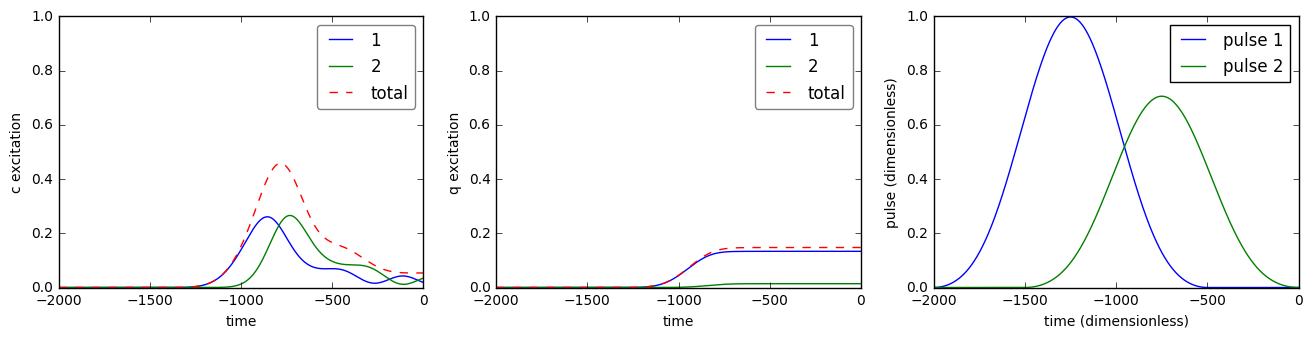

In [36]:
show_summary_dicke('rf_init', pulses='pulse*.dat')

### Optimization of initalization step

In [37]:
! mpirun -n 50 qdyn_prop_traj --n-trajs=100 --state-label=00 --use-oct-pulses rf_init

***** START OF PROGRAM qdyn_prop_traj ******
Mon Apr 3 09:57:49 -0700 2017

*** Read config file rf_init/config ***
*** Done reading config file ***
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
    2 pulses in config file
    Initializing pulse 1
   

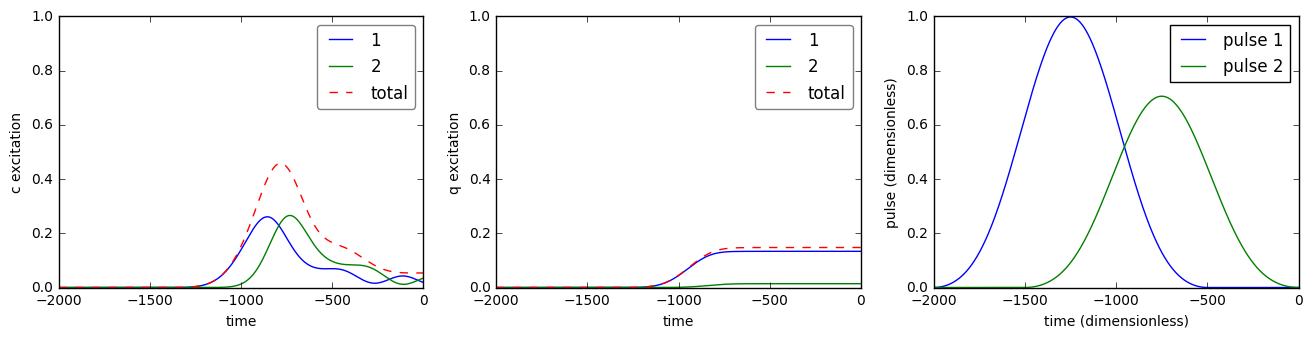

In [38]:
show_summary_dicke('rf_init', pulses='pulse*.dat')

## Example optimization commands

*   hilbert space optimization

    ```OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt --debug --J_T=J_T_re .```

*   trajectory optimization (model with `mcwf=True`)

    ```OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt --n-trajs=20 --J_T=J_T_re .```